# Connect or Collect

Este Notebook muestra el pardiagma "Connect or Collect" que permite incorporar datos externos en los analysis de IRIS sin necidad de copiar los datos, mediante la funcionalidad de <b>Foreign Tables</b>

- el CRM exporta la información de clientes en formato CSV. Accedimos a ello sin copia con Foreign Table
- La tienda online mantiene la información de pedidos en su BBDD. Accedimos a ello sin copia con Foreign Table
- La nueva empresa adquerida exporta CSV. Los importamos en IRIS con el Data Mapper de la capa de Interoperabilidad


<img src="./img/escenario.png" style="height:300px">

## Initialización

In [18]:
#Some imports
import iris,time,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set an environment variable
# os.environ['CLASSPATH'] = '/notebooks/intersystems-jdbc-3.9.0.jar'
# os.environ['JAVA_HOME']= 'usr/lib/jvm/java-11-openjdk'

## Conectar a IRIS

In [3]:
# Use JDBC and JayDeBeAPI to connect and run SQL (IRIS DB-API only allows SQL DML)
import jaydebeapi
url = "jdbc:IRIS://iris:1972/IRISAPP"
driver = "com.intersystems.jdbc.IRISDriver"
user = "SuperUser"
password = "SYS"
jarfile = "/notebooks/intersystems-jdbc-3.9.0.jar"

In [4]:
connection = jaydebeapi.connect(driver, url, [user, password], jarfile)


In [5]:
# Define Execute function
def exec_sql(sql):
    c1=connection.cursor()
    c1.execute(sql)

#Define Query execution function
def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0]
    c1.close()
    return result  

# Paradigma CONNECT

En el paradigma Connect accede a los datos in situ sin realizar ninguna copia, para casos donde no es conveniente importar los datos en IRIS.

## Referenciar Ficheros Externos

In [9]:
#Drop Foreign Server if already Exist
#exec_sql("DROP FOREIGN SERVER ext.crm CASCADE")

In [8]:
# Create Foreign Server
exec_sql("CREATE FOREIGN SERVER ext.crm FOREIGN DATA WRAPPER CSV HOST '/data/crm/'")

In [13]:
# Create the Foreign Table
exec_sql('''CREATE FOREIGN TABLE crm.clientes( 
    IDCliente VARCHAR(30),
    Nombre VARCHAR(50),
    Apellidos  VARCHAR(50),
    Genero VARCHAR(1),
    FechaNacimiento DATE,
    DireccionPais VARCHAR(20),
    DireccionCiudad VARCHAR(20),
    DireccionRegion VARCHAR(20),
    DireccionCodigoPostal VARCHAR(10)) SERVER ext.crm FILE 'clientes.csv' 
    USING '{"from":{"file":{"header":true}}}' ''')

In [19]:
#Get and Display the Contents
df=pd.read_sql("select top 5 * from crm.clientes",connection)
display(df)

,IDCliente,Nombre,Apellidos,Genero,FechaNacimiento,DireccionPais,DireccionCiudad,DireccionRegion,DireccionCodigoPostal
0,17850,José,Fernández Ferrer,M,2001-11-06,United Kingdom,None,None,None
1,13047,Antonio,Jordana Martinez,M,1970-07-07,USA,None,None,None
2,12583,Ana,López Rodriguez,F,1980-07-09,United Kingdom,None,None,None
3,13748,Celestina,Martinez López,F,2004-03-04,United Kingdom,None,None,None
4,15100,Carmen,González Martinez,F,1979-11-01,España,Sevilla,None,41001
5,17908,Javier,González Rodriguez,M,2004-10-03,USA,None,None,None
6,15291,Isabel,Jordana González,F,1976-02-27,USA,None,None,None
7,14688,Daniel,Fernández Jordana,M,2004-08-08,Francia,None,None,None
8,17809,Daniel,López Pérez,M,1975-10-28,España,Sevilla,None,41001
9,15311,Pilar,Fernández García,F,1996-09-13,United Kingdom,None,None,None


# Referenciar BBDD Externa

Para referenciar una base de datos externa, primero se tiene que instalar el driver odbc/jdbc correspondiente en el servidor/VM/docker de IRIS y definir una conexión de SQLGateway como se muestra aquí.

<img src="./img/sqlgatewayconnection.png" style="height:300px">

El Foreign Server referencia la conexión de SQL Gateway

In [36]:
#Cleanup: drop Foreing Server and Defined Tables if already exist
#exec_sql("DROP FOREIGN SERVER ext.onlinestore CASCADE")

In [37]:
#Create Foreign Server
exec_sql("create foreign server ext.onlinestore foreign data wrapper jdbc connection 'onlinestore'")

In [39]:
#Create Foreign Table
exec_sql('''
    CREATE FOREIGN TABLE onlinestore.orders(
    id bigint,
    invoice VARCHAR(20),
    stockcode VARCHAR(20),
    description VARCHAR(100),
    quantity INTEGER,
    invoicedate Date,
    price NUMERIC,
    customerid VARCHAR(10)
    --,country VARCHAR(50)
    ) server ext.onlinestore table 'public.orders'
''')

In [40]:
#Get and Display the Contents
df=pd.read_sql("select top 5 * from onlinestore.orders",connection)
display(df)

,id,invoice,stockcode,description,quantity,invoicedate,price,customerid
0,1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,3,17850
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3,17850
2,3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,3,17850
3,4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3,17850
4,5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3,17850


# Juntar los Datos

Ahora podemos executar Queries SQL que hagan Joins entre las tablas de los distintos Foreign servers.

In [51]:
sql=''' select o.invoice, o.stockcode, o.description, o.customerid, 
        c.IDCliente, c.nombre, c.apellidos
        FROM onlinestore.orders o LEFT OUTER JOIN crm.clientes c
        on o.customerid = c.IDCliente
        where o.customerid in ('17850','13047','12853')
    '''
df=pd.read_sql(sql,connection)
display(df)

,invoice,stockcode,description,customerid,IDCliente,Nombre,Apellidos
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17850,17850,José,Fernández Ferrer
1,536365,71053,WHITE METAL LANTERN,17850,17850,José,Fernández Ferrer
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,17850,17850,José,Fernández Ferrer
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,17850,17850,José,Fernández Ferrer
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,17850,17850,José,Fernández Ferrer
...,...,...,...,...,...,...,...
587,571185,23487,SWEET HEART CAKE CARRIER,13047,13047,Antonio,Jordana Martinez
588,571185,23109,PACK OF SIX LED TEA LIGHTS,13047,13047,Antonio,Jordana Martinez
589,571185,23434,3 RAFFIA RIBBONS 50'S CHRISTMAS,13047,13047,Antonio,Jordana Martinez
590,571185,22086,PAPER CHAIN KIT 50'S CHRISTMAS,13047,13047,Antonio,Jordana Martinez


In [63]:
#Sales by Gender
sql=''' select SUM (o.quantity) as total_quantity, c.genero as genero
        FROM onlinestore.orders o LEFT OUTER JOIN crm.clientes c
        on o.customerid = c.IDCliente
        group by c.genero
    '''
df=pd.read_sql(sql,connection)
df.head()

,total_quantity,genero
0,269562,None
1,2339390,F
2,2567499,M


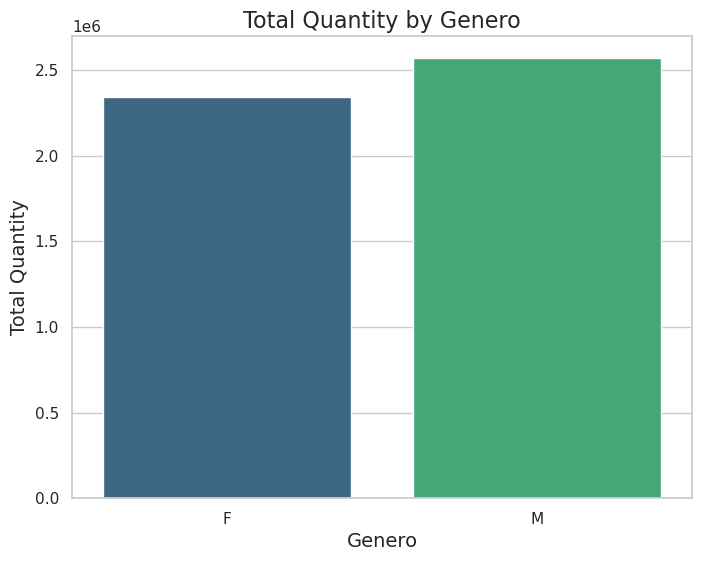

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn theme for better visuals
sns.set_theme(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='genero', y='total_quantity', palette="viridis")

# Add labels and a title
plt.title("Total Quantity by Genero", fontsize=16)
plt.xlabel("Genero", fontsize=14)
plt.ylabel("Total Quantity", fontsize=14)

# Show the plot
plt.show()

# Foreign Server: Queries Passthrough

Es posible enviar queries SQL a un foreign server en modo "passthrough", directamente con la sinytaxis SQL del motor remoto

In [65]:
df=pd.read_sql("THROUGH foreign server ext.onlinestore select * from public.orders LIMIT 2",connection)
display(df)

,id,invoice,stockcode,description,quantity,invoicedate,price,customerid,country
0,1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,3,17850,United Kingdom
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3,17850,United Kingdom


# Paradigma COLLECT

En el paradigma collect, se realiza una carga de datos. El comando SQL "LOAD DATA" permite hace importaciones massivas de datos externos limpios, sea desde fichero o servidor externo accesible por JDBC.
Este mecanismo usa internamente el Java Gateway.

## Carga desde Ficheros Externos

Requiere definir la tabla donde cargar los datos, y mapear todo los campos del fichero.

In [89]:
# Prepare the target Table. The table needs to be created
# /data/superstore/superstore.csv
# Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,
#  State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit

#exec_sql('Drop table bulk.superstore')

sql=''' CREATE TABLE bulk.superstore (
    OrderID VARCHAR(30),OrderDate VARCHAR(30), 
    CustomerID VARCHAR(30),
    Category VARCHAR(30),
    ProductName VARCHAR(100),
    Sales DOUBLE,
    Quantity INTEGER)
    '''
exec_sql(sql)

In [90]:
sql=''' LOAD DATA FROM FILE '/data/superstore/superstore.csv'
    COLUMNS ( "Row ID" VARCHAR(20),
    "Order ID" VARCHAR(30) ,"Order Date" VARCHAR(30), "Ship Date" VARCHAR(30),"Ship Mode" VARCHAR(10),
    "Customer ID" VARCHAR(30),"Customer Name" VARCHAR(30), Segment VARCHAR(30), Country VARCHAR(30),
    City VARCHAR(30),"State" VARCHAR(30),"Postal Code" VARCHAR(30), Region VARCHAR(30),"Product ID" VARCHAR(30),
    Category VARCHAR(30),"Sub-Category" VARCHAR(30),"Product Name" VARCHAR(100), Sales DOUBLE, Quantity INTEGER
    )
    INTO bulk.superstore (OrderID, CustomerID, OrderDate, Category, ProductName, Sales, Quantity)
    VALUES("Order ID","Customer ID","Order Date","Category","Product Name",Sales, Quantity)
    USING {"from":{"file":{"header":true}}}
    '''
exec_sql(sql)


In [91]:
## Carga desde Base de datos Externos
df=pd.read_sql('select top 5 * from bulk.superstore',connection)
display(df)

,OrderID,OrderDate,CustomerID,Category,ProductName,Sales,Quantity
0,CA-2013-152156,09-11-2013,CG-12520,Furniture,Bush Somerset Collection Bookcase,261.9600,2
1,CA-2013-152156,09-11-2013,CG-12520,Furniture,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3
2,CA-2013-138688,13-06-2013,DV-13045,Office Supplies,Self-Adhesive Address Labels for Typewriters b...,14.6200,2
3,US-2012-108966,11-10-2012,SO-20335,Furniture,Bretford CR4500 Series Slim Rectangular Table,957.5775,5
4,US-2012-108966,11-10-2012,SO-20335,Office Supplies,Eldon Fold 'N Roll Cart System,22.3680,2


## Carga desde tabla Externa

In [95]:
 sql='''
    CREATE TABLE bulk.orders(
    id bigint,
    invoice VARCHAR(20),
    stockcode VARCHAR(20),
    description VARCHAR(100),
    quantity INTEGER,
    invoicedate Date,
    price NUMERIC,
    customerid VARCHAR(10)
    )
    '''
exec_sql(sql)

In [97]:
sql=''' LOAD DATA FROM JDBC CONNECTION onlinestore
        TABLE "public"."orders"
        INTO bulk.orders(id, invoice, stockcode, description, quantity, invoicedate, price, customerid)
        VALUES(id, invoice, stockcode, description, quantity, invoicedate, price, customerid)
    '''
exec_sql(sql)

In [99]:
## Carga desde Base de datos Externos
df=pd.read_sql('select top 5 * from bulk.orders',connection)
display(df)

,id,invoice,stockcode,description,quantity,invoicedate,price,customerid
0,1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,3,17850
1,2,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3,17850
2,3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,3,17850
3,4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3,17850
4,5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3,17850


## Notas adicionales de Carga Rapida

Las opciones siguientes permiten accelerar la carga massiva de datos. 
Construir los Indices al final de la carga es más eficiente:
LOAD BULK
LOAD %NOJOURN BULK


##